In [3]:
import json
import os
import argparse
import pathlib
import pandas as pd
from glob import glob
import rouge
import nltk
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
def sort_by_score(x):
		return x["prediction"]

def get_text_and_scores(result_path):
	df = pd.read_csv(result_path, sep='\t', engine='python')
	text = df["text"].astype(str)
	predictions = df["score"].astype(float)
	assert len(predictions) == len(text)
	# print(predictions)
	# print(text)
	return {"predictions": list(predictions), "text": list(text), "filename": result_path}

def get_human_summary(summary_path):
    with open("../../booksum/scripts/" + summary_path, encoding='utf-8') as f:
        summary_json = json.load(f)
        return summary_json["summary"]

def generate_concat_summary(related_files, k):
	cat_related_files = []
	generated_summary = ""
	for related_file in related_files:
		cat_related_files.extend([{"prediction": related_file["predictions"][idx],\
			 "text": related_file["text"][idx]} for idx in range(len(related_file["predictions"]))])
	cat_related_files.sort(key=sort_by_score, reverse=True)
	cat_related_files = cat_related_files[:((k+1)*len(related_files))]
	#Concat summary sentences into one string.
	for sentence in cat_related_files:
		generated_summary = generated_summary + " " + sentence["text"]
	# Removes first " "
	generated_summary = generated_summary[1:]
	return generated_summary

def generate_each_summary(related_files, k):
	generated_summary_list = []
	related_files_list = []
	generated_summary = ""
	for related_file in related_files:
		related_files_list.append([{"prediction": related_file["predictions"][idx],\
			 "text": related_file["text"][idx]} for idx in range(len(related_file["predictions"]))])
	for related_file in related_files_list:
		related_file.sort(key=sort_by_score, reverse=True)
		generated_summary_list.extend(related_file[:(k+1)])
	#Concat summary sentences into one string.
	for sentence in generated_summary_list:
		generated_summary = generated_summary + " " + sentence["text"]
	# Removes first " "
	generated_summary = generated_summary[1:]
	return generated_summary

In [5]:
input_path_list = glob(os.path.normpath("../../PreSumm/results/booksum_summaries/20000/") + "/*")
text_and_scores = [get_text_and_scores(result_path) for result_path in input_path_list]
used_files = []
results= []
# 	"each": {
# 		"f1": [], # Shape: float

# 	},
# 	"concat": {
# 		"f1": [], # Shape: float
# 	},
# 	"p_value": [],  # Shape: float
# 	"diff_data": [], # Shape: [k, f1_score, summary_path]
# }

max_k = 10
if max_k < 1:
    print("k must be greater than 0.")
    raise

for k in range(max_k):

    f = open(pathlib.Path("../../booksum/alignments/book-level-summary-alignments/book_summaries_aligned_all.jsonl"), \
        encoding='utf-8')
    
    book_count = 0

    curr_result = {
        "each": {
            "f1": [], # Shape: float
        },
        "concat": {
            "f1": [], # Shape: float
        },
        "p_value": float,
        "diff_data": [], # Shape:[f1_score, summary_path]
    }

    for line in f:
        # print(line)
        content = json.loads(line)
        summary_path = content['summary_path']
        book_title = content['title']
        source = content['source']
        # Format title.
        book_title = book_title.replace(':', "").replace(" ", "_").lower()

        try:
            human_summary = get_human_summary(summary_path)
            # print("Summary Length : {}".format(len(human_summary)))
        except:
            human_summary = None
            print("Could not find summary.")
        
        # pull out all files related to that summary from data.
        related_files = list(filter(lambda x: source in x['filename'] and book_title in x['filename'], text_and_scores))
        used_files.extend(related_files)

        if len(related_files) == 0:
            continue

        elif (human_summary is None):
            print("Files exist but no summary.")
            print(summary_path)

        # Generate extractive summaries.
        extractive_concat_summary = generate_concat_summary(related_files, k)
        extractive_each_summary = generate_each_summary(related_files, k)

        evaluator = rouge.Rouge(metrics=['rouge-n'],
                    max_n=1,
                    limit_length=False)
        concat_scores = evaluator.get_scores(extractive_concat_summary, human_summary)
        each_scores = evaluator.get_scores(extractive_each_summary, human_summary)
        curr_result["each"]["f1"].append(each_scores['rouge-1']['f'])
        curr_result["concat"]["f1"].append(concat_scores['rouge-1']['f'])
        curr_result["diff_data"].append([k, concat_scores['rouge-1']['f'] - each_scores['rouge-1']['f'], summary_path])
        book_count += 1
    

    results.append(curr_result)
    print("k: {}".format(k+1))
    print("Books covered: {}".format(book_count))
    
    paired_t_test = stats.ttest_rel(curr_result["concat"]["f1"], curr_result["each"]["f1"])
    curr_result["p_value"] = paired_t_test.pvalue
    print("P Value: {} < 0.05 = {}".format(paired_t_test.pvalue, str(paired_t_test.pvalue < 0.05)))
    print()

k: 1
Books covered: 400
P Value: 1.1822217209336366e-05 < 0.05 = True

k: 2
Books covered: 400
P Value: 0.29375800649293543 < 0.05 = False

k: 3
Books covered: 400
P Value: 0.6304508664672492 < 0.05 = False

k: 4
Books covered: 400
P Value: 0.059777121539747985 < 0.05 = False

k: 5
Books covered: 400
P Value: 0.017835096756391725 < 0.05 = True

k: 6
Books covered: 400
P Value: 0.0004953135499411025 < 0.05 = True

k: 7
Books covered: 400
P Value: 1.0572580479732677e-10 < 0.05 = True

k: 8
Books covered: 400
P Value: 2.348625030817464e-12 < 0.05 = True

k: 9
Books covered: 400
P Value: 1.6081003301187514e-15 < 0.05 = True

k: 10
Books covered: 400
P Value: 1.568160284652677e-17 < 0.05 = True



Drawing graph...


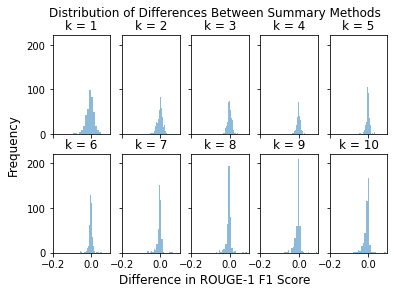

In [12]:
print("Drawing graph...")
fig, axes = plt.subplots(2, 5, sharex=True, sharey=True)
for k, ax in zip(range(max_k), axes.flatten()):
    diff_data = [x[1] for x in results[k]["diff_data"]]
    ax.hist(diff_data, alpha=0.5, bins=20)
    ax.set_title("k = {}".format(k+1))
plt.suptitle("Distribution of Differences Between Summary Methods")
fig.supxlabel("Difference in ROUGE-1 F1 Score")
fig.supylabel("Frequency")
plt.xlim([-0.2, 0.1])
plt.savefig("../graphs/booksum_summaries_dists.pdf")
plt.show()